# The IQ-OTH/NCCD lung cancer dataset
## Lung Cancer CT Scans from Iraqi hospitals: Normal, Benign, and Malignant Cases

## About Dataset
The Iraq-Oncology Teaching Hospital/National Center for Cancer Diseases (IQ-OTH/NCCD) lung cancer dataset was collected in the above-mentioned specialist hospitals over a period of three months in fall 2019. It includes CT scans of patients diagnosed with lung cancer in different stages, as well as healthy subjects. IQ-OTH/NCCD slides were marked by oncologists and radiologists in these two centers. The dataset contains a total of 1190 images representing CT scan slices of 110 cases. These cases are grouped into three classes: normal, benign, and malignant. of these, 40 cases are diagnosed as malignant; 15 cases diagnosed with benign; and 55 cases classified as normal cases. The CT scans were originally collected in DICOM format. The scanner used is SOMATOM from Siemens. CT protocol includes: 120 kV, slice thickness of 1 mm, with window width ranging from 350 to 1200 HU and window center from 50 to 600 were used for reading. with breath hold at full inspiration. All images were de-identified before performing analysis. Written consent was waived by the oversight review board. The study was approved by the institutional review board of participating medical centers. Each scan contains several slices. The number of these slices range from 80 to 200 slices, each of them represents an image of the human chest with different sides and angles. The 110 cases vary in gender, age, educational attainment, area of residence and living status. Some of them are employees of the Iraqi ministries of Transport and Oil, others are farmers and gainers. Most of them come from places in the middle region of Iraq, particularly, the provinces of Baghdad, Wasit, Diyala, Salahuddin, and Babylon.

if you use this dataset you should cite the following articles:

1- Diagnosis of lung cancer based on CT scans using CNN
can be cited as :
(H. F. Al-Yasriy, M. S. Al-Husieny, F. Y. Mohsen, E. A. Khalil, and Z. S. Hassan, "Diagnosis of Lung Cancer Based on CT Scans Using CNN," IOP Conference Series: Materials Science and Engineering, vol. 928, 2020.)

2- Evaluation of SVM performance in the detection of lung cancer in marked CT scan dataset
can be cited as:
(H. F. Kareem, M. S. A.-Husieny, F. Y. Mohsen, E. A. Khalil, and Z. S. Hassan, “Evaluation of SVM performance in the detection
of lung cancer in marked CT scan dataset,” Indonesian Journal of Electrical Engineering and Computer Science, vol. 21, no. 3,
pp. 1731-1738, 2021, doi: 10.11591/ijeecs.v21.i3.pp1731-1738.)

3- The IQ-OTH/NCCD lung cancer dataset
can be cited as :
(alyasriy, hamdalla; AL-Huseiny, Muayed (2023), “The IQ-OTH/NCCD lung cancer dataset”, Mendeley Data, V4, doi: 10.17632/bhmdr45bh2.4)

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout 
import tensorflow as tf

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
pd.set_option('display.max_colwidth', None)

In [2]:
directory = r"lung_cancer_dataset"
categories = ["Bengin cases", "Malignant cases", "Normal cases"]

benign_directory = directory + "/" + categories[0]
malignant_directory = directory + "/" + categories[1]
normal_directory = directory + "/" + categories[2]

In [3]:
# saving the path of all data in dictionary
path_list = []
category_list = []
for category in categories:
    folder_path = os.path.join(directory, category)
    folder_image_contents = os.listdir(folder_path)
    for image_file in folder_image_contents:
        image_file_path = os.path.join(folder_path, image_file)
        path_list.append(image_file_path)
        category_list.append(category)

path_series = pd.Series(path_list, name="filepath")
category_series = pd.Series(category_list, name="category")

image_paths_df = pd.DataFrame(path_series).join(category_series)

image_paths_df.head()        

,filepath,category
0,lung_cancer_dataset\Bengin cases\Bengin case (1).jpg,Bengin cases
1,lung_cancer_dataset\Bengin cases\Bengin case (10).jpg,Bengin cases
2,lung_cancer_dataset\Bengin cases\Bengin case (100).jpg,Bengin cases
3,lung_cancer_dataset\Bengin cases\Bengin case (101).jpg,Bengin cases
4,lung_cancer_dataset\Bengin cases\Bengin case (102).jpg,Bengin cases


# Image resizing

Bengin cases


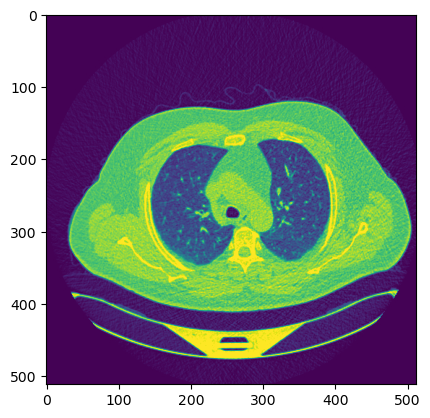

Malignant cases


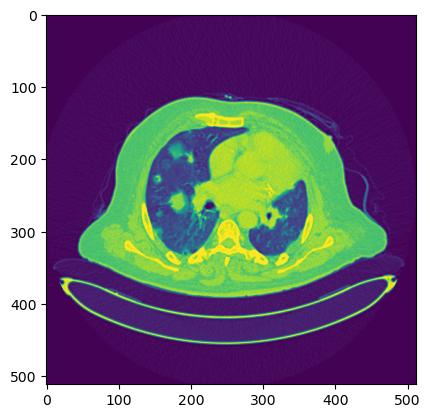

Normal cases


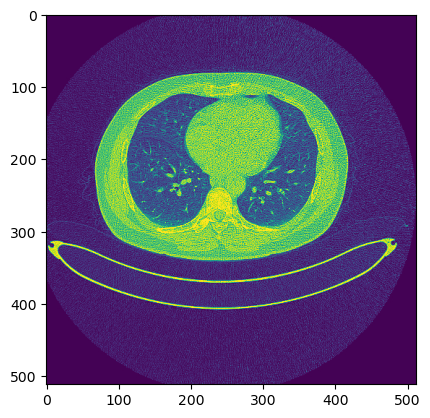

{'Bengin cases': {'512 x 512': 120}, 'Malignant cases': {'512 x 512': 501, '404 x 511': 1, '512 x 801': 28, '512 x 623': 31}, 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}


,Bengin cases,Malignant cases,Normal cases
512 x 512,120.0,501.0,415.0
404 x 511,NaN,1.0,NaN
512 x 801,NaN,28.0,NaN
512 x 623,NaN,31.0,NaN
331 x 506,NaN,NaN,1.0


In [4]:
# read image size and put it into dataframe
size_data = {}
is_grayscale = 0 # enter 0 for color, 1 for grayscale
for category in categories:
    folder_path = os.path.join(directory, category)
    folder_image_contents = os.listdir(folder_path)
    image_sizes_in_one_category = {}
    print(category)
    for image_file in folder_image_contents:
        image_file_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_file_path)
        height, width, channel = img.shape
        if(str(height) + " x " + str(width) in image_sizes_in_one_category):
            image_sizes_in_one_category[str(height) + " x " + str(width)] += 1
        else:
            image_sizes_in_one_category[str(height) + " x " + str(width)] = 1
    plt.imshow(cv2.imread(image_file_path, is_grayscale))
    plt.show()
    size_data[category] = image_sizes_in_one_category
size_data_df = pd.DataFrame(size_data)
print(size_data)
size_data_df.head(10)

Malignant cases


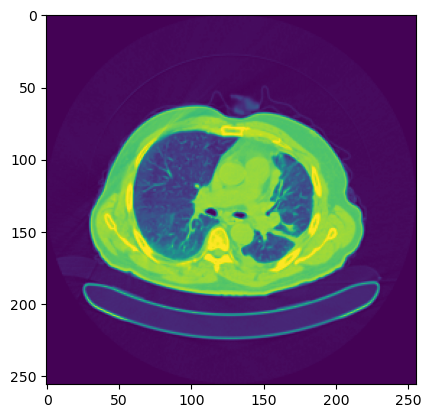

In [5]:
dataset = []
desired_size = 256
for index, row in image_paths_df.iterrows():
    filepath = row["filepath"]
    img = cv2.imread(filepath, is_grayscale)
    img = cv2.resize(img, (desired_size, desired_size))
    label = row["category"]
    dataset.append([img, label])
    
random.shuffle(dataset)

print(dataset[0][1])
plt.imshow(dataset[0][0])
plt.show()

# Image smoothing

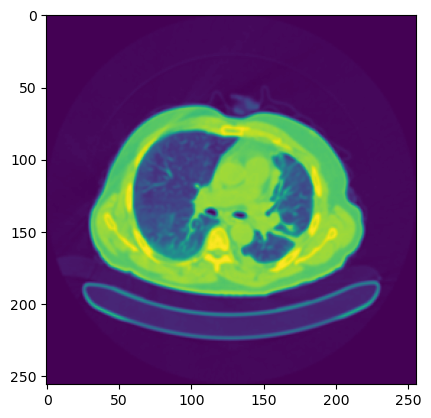

In [6]:
# using gaussian blur
kernel_shape = 3
for data in dataset:
    img = cv2.GaussianBlur(data[0], (kernel_shape, kernel_shape), 0)
    data[0] = img

plt.imshow(dataset[0][0])
plt.show()

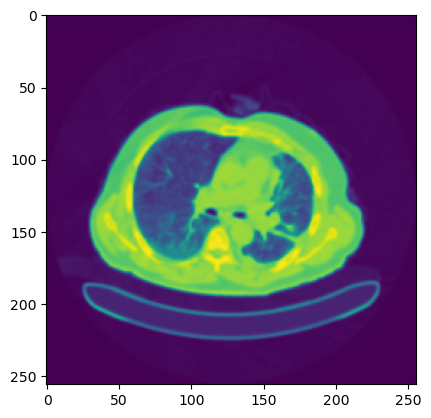

In [7]:
# using bilateral filtering
diameter = 3
sigma_color = 25
sigma_space = 25
for data in dataset:
    img = cv2.bilateralFilter(data[0], diameter, sigma_color, sigma_space)
    data[0] = img

plt.imshow(dataset[0][0])
plt.show()

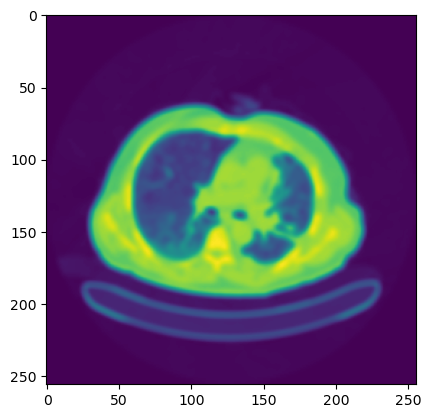

In [8]:
# using 2d convolution
kernel_size = 5
kernel_ = np.ones((kernel_size, kernel_size), np.float32)/(kernel_size*kernel_size)
for data in dataset:
    img = cv2.filter2D(src=data[0], ddepth=-1, kernel=kernel_)
    data[0] = img

plt.imshow(dataset[0][0])
plt.show()

# Data normalization

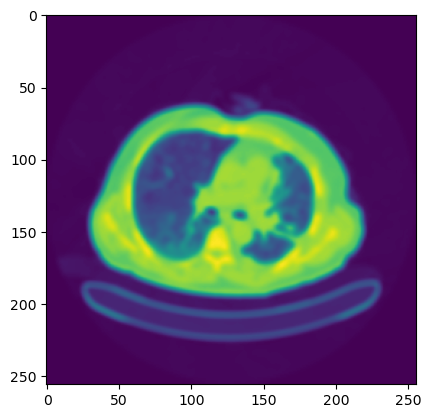

In [9]:
# using min-max scaling
for data in dataset:
    img = data[0]/255.0
    data[0] = img

plt.imshow(dataset[0][0])
plt.show()

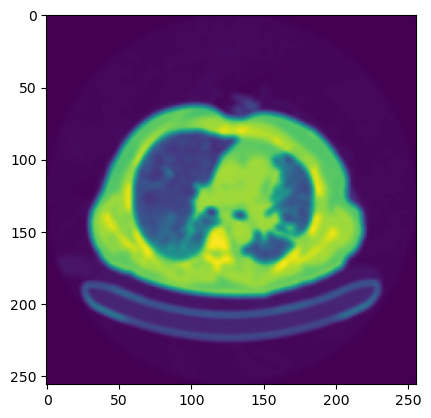

In [10]:
# using standardization
for data in dataset:
    mean, std = cv2.meanStdDev(data[0])
    img = (data[0] - mean) / std
    data[0] = img

plt.imshow(dataset[0][0])
plt.show()

# Data splitting

In [11]:
x, y = [], []
for image, category in dataset:
    x.append(image)
    y.append(category)

x = np.array(x)
y = np.array(y)
    
x, x_test, y, y_test = train_test_split(x, y, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.33, random_state = 15, stratify=y)

# Handling data imbalance

In [12]:
# using SMOTE (like example)
print(x_train.shape)
number_of_samples = x_train.shape[0]
x_train = x_train.reshape(number_of_samples, -1)
print(x_train.shape)

print("before: ", Counter(y_train))

x_train_smt, y_train_smt = SMOTE().fit_resample(x_train, y_train)

print("after: ", Counter(y_train_smt))
x_train = x_train.reshape(number_of_samples, desired_size, desired_size, 1)
x_train_smt = x_train_smt.reshape(x_train_smt.shape[0], desired_size, desired_size, 1)
print(x_train.shape)
print(x_train_smt.shape)

(587, 256, 256)
(587, 65536)
before:  Counter({'Malignant cases': 297, 'Normal cases': 229, 'Bengin cases': 61})
after:  Counter({'Normal cases': 297, 'Malignant cases': 297, 'Bengin cases': 297})
(587, 256, 256, 1)
(891, 256, 256, 1)


In [13]:
# using near miss algorithm
    

In [14]:
# using image augmentation


In [15]:
# using class weightings


In [16]:
# using balanced bagging classifier


In [17]:
# using k-fold cross-validation


# Data models

In [18]:
# Using CNN
model_cnn = Sequential()
model_cnn.add(Conv2D(128, (3, 3), activation="relu", input_shape=x_train.shape[1:]))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(128, (3, 3), 1, activation="relu"))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(64, (3, 3), 1, activation="relu"))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(3, activation='softmax'))
              
model_cnn.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
model_cnn.summary()

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,969,283 (57.10 MB)

 Trainable params: 14,969,283 (57.10 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
label_encoder = LabelEncoder()

# Convert string categories to integer labels
y_train_smt = label_encoder.fit_transform(y_train_smt)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# apply one-hot encoding
y_train_smt = to_categorical(y_train_smt, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)


# model fitting
history = model_cnn.fit(x_train_smt, y_train_smt, batch_size = 10, epochs = 11, validation_data = (x_val, y_val), callbacks=[tensorboard_callback])
history.history

Epoch 1/11
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 506ms/step - accuracy: 0.6212 - loss: 0.9013 - val_accuracy: 0.9241 - val_loss: 0.2791
Epoch 2/11
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 506ms/step - accuracy: 0.9664 - loss: 0.1278 - val_accuracy: 0.8724 - val_loss: 0.3438
Epoch 3/11
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 528ms/step - accuracy: 0.9606 - loss: 0.0837 - val_accuracy: 0.9517 - val_loss: 0.1560
Epoch 4/11
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 520ms/step - accuracy: 0.9902 - loss: 0.0270 - val_accuracy: 0.9483 - val_loss: 0.1398
Epoch 5/11
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 522ms/step - accuracy: 0.9844 - loss: 0.0635 - val_accuracy: 0.9586 - val_loss: 0.1506
Epoch 6/11
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 536ms/step - accuracy: 0.9867 - loss: 0.0660 - val_accuracy: 0.9448 - val_loss: 0.1808
Epoch 7/11
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 526ms/step - accuracy: 0.9972 - loss: 0.0101 - val_accuracy: 0.9517 - val_loss: 0.1185
Epoch 8/11
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 544ms/step - accuracy: 0.9969 - loss: 0.0094 - val_accu

{'accuracy': [0.7665544152259827,
  0.9685746431350708,
  0.9764309525489807,
  0.9876543283462524,
  0.9719416499137878,
  0.9921436309814453,
  0.996632993221283,
  0.9988776445388794,
  0.9977553486824036,
  0.996632993221283,
  0.9955106377601624],
 'loss': [0.5792787671089172,
  0.11464519798755646,
  0.059682220220565796,
  0.04290704429149628,
  0.10283491015434265,
  0.04493638128042221,
  0.017369236797094345,
  0.004410312045365572,
  0.005386315751820803,
  0.018445435911417007,
  0.011403013952076435],
 'val_accuracy': [0.9241379499435425,
  0.8724138140678406,
  0.951724112033844,
  0.9482758641242981,
  0.9586206674575806,
  0.9448275566101074,
  0.951724112033844,
  0.9620689749717712,
  0.9620689749717712,
  0.9551724195480347,
  0.951724112033844],
 'val_loss': [0.27912187576293945,
  0.34382128715515137,
  0.15601438283920288,
  0.13983845710754395,
  0.15064691007137299,
  0.18075911700725555,
  0.118504598736763,
  0.15347808599472046,
  0.14494767785072327,
  0.127

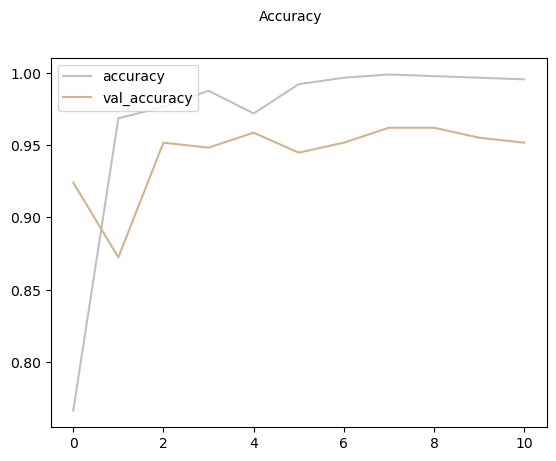

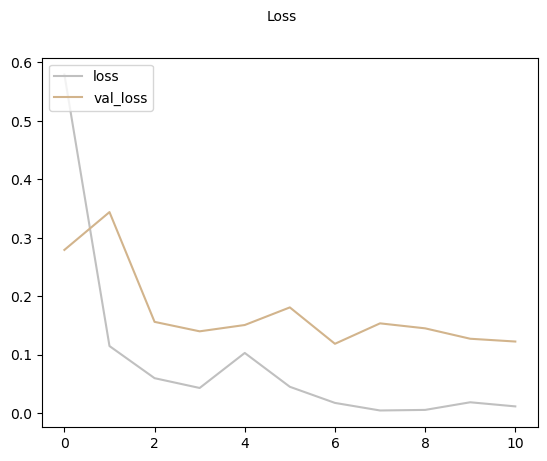

In [20]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='silver', label='accuracy')
plt.plot(history.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(history.history['loss'], color='silver', label='loss')
plt.plot(history.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper left")
plt.show()

In [21]:
y_pred = model_cnn.predict(x_test)
def accuracy(y_test, y_pred):
    correct_predictions = 0
    for yt, yp in zip(y_test, y_pred):
        if yt==yp:
            correct_predictions+=1;
    return correct_predictions / len(y_test)
accuracy(y_test, y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
from sklearn import metrics
print("Shape of y_test:", y_test.shape)  # Should be 1D, e.g., (N,)
print("Shape of y_pred:", y_pred.shape)  # Should be 2D, e.g., (N, num_classes)
print("y_test data type:", type(y_test[0]))
print("y_pred_labels data type:", type(y_pred_labels[0]))
print("y_test data type:", y_test[0])
print("y_pred_labels data type:", y_pred_labels[0])

#y_test = np.argmax(y_test, axis=1)  # Shape becomes (220,)


print("Shape of y_test:", y_test.shape)  # Should be 1D, e.g., (N,)
print("Shape of y_pred:", y_pred.shape)  # Should be 2D, e.g., (N, num_classes)
print("y_test data type:", type(y_test[0]))
print("y_pred_labels data type:", type(y_pred_labels[0]))
print("y_test data type:", y_test[0])
print("y_pred_labels data type:", y_pred_labels[0])

y_pred = model_cnn.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)

label_encoder.fit(categories)
print(label_encoder.classes_)
for i in range(1, len(label_encoder.classes_)):
    print(i + " = ")
    print(label_encoder.classes_[i])
    
# print(metrics.accuracy_score(y_test, y_pred_labels))
print(metrics.classification_report(y_test, y_pred_labels))


Shape of y_test: (220,)
Shape of y_pred: (220, 3)
y_test data type: <class 'numpy.int64'>
y_pred_labels data type: <class 'numpy.int64'>
y_test data type: 2
y_pred_labels data type: 2
Shape of y_test: (220,)
Shape of y_pred: (220, 3)
y_test data type: <class 'numpy.int64'>
y_pred_labels data type: <class 'numpy.int64'>
y_test data type: 2
y_pred_labels data type: 2
1/7 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step